In [1]:
import pandas as pd
import sqlite3

In [2]:
# Load the data
df = pd.read_excel("owid-co2-data.xlsx")

In [3]:
# Display the first few rows of the DataFrame
df.head()

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1850,AFG,3752993.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1851,AFG,3767956.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.165,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,Afghanistan,1852,AFG,3783940.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.164,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,Afghanistan,1853,AFG,3800954.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.164,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,Afghanistan,1854,AFG,3818038.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.163,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [4]:
# Connect to the SQLite database
conn = sqlite3.connect('co2_data.db')

In [5]:
# Write the DataFrame to a SQLite table
df.to_sql('co2_data', conn, if_exists='replace', index=False)

In [6]:
# Query to examine trends in annual CO2 emissions
query1 = """
SELECT year, SUM(co2) AS total_co2_emissions
FROM co2_data
GROUP BY year
ORDER BY year;
"""

In [7]:
# Execute the query
result1 = pd.read_sql_query(query1, conn)
print(result1.head())

   year  total_co2_emissions
0  1750               55.836
1  1751               56.442
2  1752               57.030
3  1753               57.660
4  1754               58.404


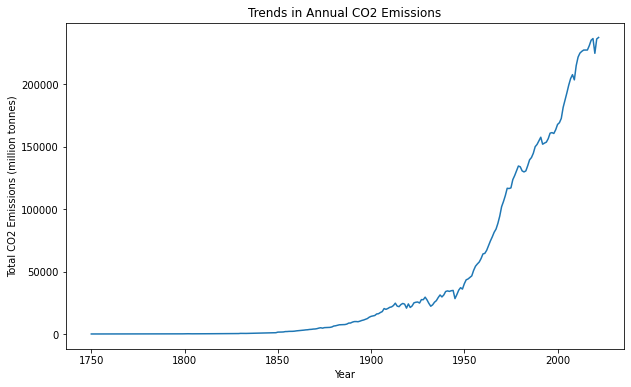

In [8]:
import matplotlib.pyplot as plt

# Plot trends in annual CO2 emissions
plt.figure(figsize=(10, 6)) 
plt.plot(result1['year'], result1['total_co2_emissions'])
plt.xlabel('Year')
plt.ylabel('Total CO2 Emissions (million tonnes)')
plt.title('Trends in Annual CO2 Emissions')
plt.show()

In [9]:
# Query to analyze per capita emissions by countries in the last 10 years
query2 = """
SELECT country, AVG(co2_per_capita) AS avg_co2_per_capita_last_10_years
FROM (
    SELECT country, co2_per_capita
    FROM co2_data
    WHERE year >= (SELECT MAX(year) - 9 FROM co2_data) -- Filter data for the last 10 years
) AS recent_data
GROUP BY country
ORDER BY avg_co2_per_capita_last_10_years DESC;
"""

In [10]:
# Execute the query
result2 = pd.read_sql_query(query2, conn)
print(result2.head())

                country  avg_co2_per_capita_last_10_years
0                 Qatar                           37.5320
1   Trinidad and Tobago                           27.2169
2               Curacao                           24.7378
3  United Arab Emirates                           24.3315
4               Bahrain                           24.1151


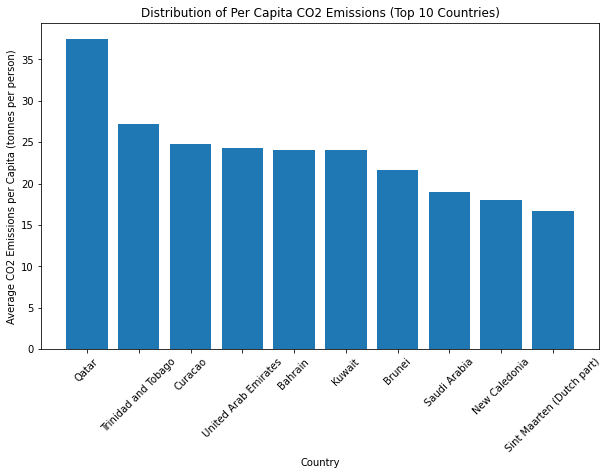

In [11]:
# Plot distribution of per capita emissions
plt.figure(figsize=(10, 6))
plt.bar(result2['country'][:10], result2['avg_co2_per_capita_last_10_years'][:10])
plt.xlabel('Country')
plt.ylabel('Average CO2 Emissions per Capita (tonnes per person)')
plt.title('Distribution of Per Capita CO2 Emissions (Top 10 Countries)')
plt.xticks(rotation=45)
plt.show()

In [12]:
# This query calculates the total cumulative CO2 emissions for each country over the entire period covered by the data.
query3 = """
    SELECT
        iso_code,
        SUM(cumulative_co2) AS total_cumulative_co2
    FROM
        co2_data
    WHERE
        year >= (SELECT MAX(year) - 9 FROM co2_data)
        AND iso_code IS NOT NULL -- Selecting data for the last 50 years
    GROUP BY
        iso_code
    ORDER BY
        total_cumulative_co2 DESC;
"""

In [13]:
result3 = pd.read_sql_query(query3, conn)
N = 10  # Number of top countries to display
top_countries = result3.nlargest(N, 'total_cumulative_co2')

In [14]:
top_countries

,iso_code,total_cumulative_co2
0,USA,4039018.811
1,CHN,2121365.250
2,RUS,1117633.001
3,DEU,907947.978
4,GBR,772296.913
5,JPN,627688.776
6,IND,481565.770
7,FRA,380031.605
8,CAN,321238.974
9,UKR,300425.375


In [15]:
top_countries_sorted = top_countries.sort_values(by='total_cumulative_co2', ascending=True)

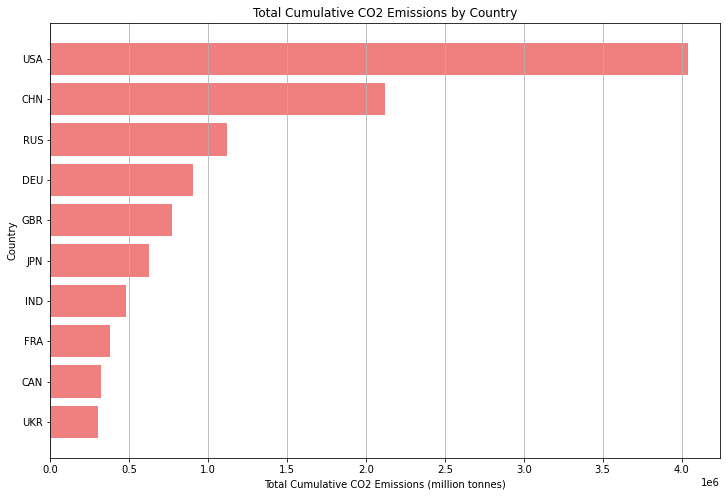

In [16]:
plt.figure(figsize=(12, 8))
plt.barh(top_countries_sorted['iso_code'], top_countries_sorted['total_cumulative_co2'], color='lightcoral')
plt.xlabel('Total Cumulative CO2 Emissions (million tonnes)')
plt.ylabel('Country')
plt.title('Total Cumulative CO2 Emissions by Country')
plt.grid(axis='x')

plt.show()

In [17]:
# The query below calculates the average CO2 growth percentage over the last 10 years for top 5 countries 
query4 = """
    SELECT iso_code, AVG(co2_growth_prct) AS avg_growth_prct
    FROM co2_data
    WHERE year >= (SELECT MAX(year) - 9 FROM co2_data) -- Select data from the last 10 years
    GROUP BY iso_code
    ORDER BY avg_growth_prct DESC
    LIMIT 5; -- Select top 5 ISO codes with the highest average CO2 growth percentage
"""

# Execute the query and fetch the results
result4 = pd.read_sql(query4, conn)

# Display the results
result4

,iso_code,avg_growth_prct
0,LAO,25.3369
1,MOZ,15.1346
2,KHM,14.1329
3,TJK,14.0546
4,MMR,12.5380


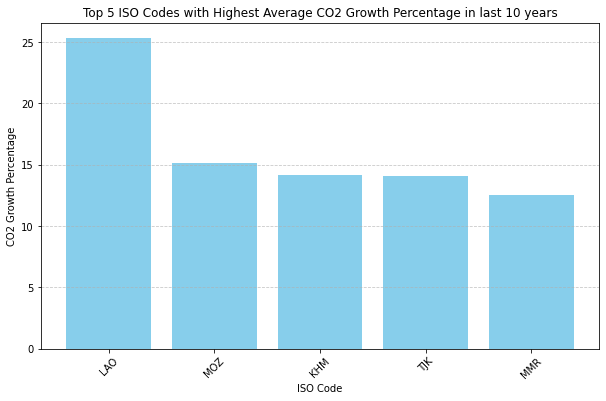

In [18]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(result4['iso_code'], result4['avg_growth_prct'], color='skyblue')
plt.title('Top 5 ISO Codes with Highest Average CO2 Growth Percentage in last 10 years')
plt.xlabel('ISO Code')
plt.ylabel('CO2 Growth Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Transform Data for Visualization

In [19]:
id_vars = ['iso_code', 'year', 'country']

# List of columns to melt
value_vars = ['cement_co2', 'coal_co2', 'consumption_co2', 'flaring_co2', 'gas_co2', 'oil_co2', 'trade_co2']

# Melt the DataFrame to reshape it
melted_df = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='CO2 Emission Type', value_name='Value')

  iso_code  year      country CO2 Emission Type  Value
0      AFG  1850  Afghanistan        cement_co2    NaN
1      AFG  1851  Afghanistan        cement_co2    NaN
2      AFG  1852  Afghanistan        cement_co2    NaN
3      AFG  1853  Afghanistan        cement_co2    NaN
4      AFG  1854  Afghanistan        cement_co2    NaN


In [20]:
melted_df.tail()

,iso_code,year,country,CO2 Emission Type,Value
336401,ZWE,2018,Zimbabwe,trade_co2,-0.088
336402,ZWE,2019,Zimbabwe,trade_co2,0.143
336403,ZWE,2020,Zimbabwe,trade_co2,0.818
336404,ZWE,2021,Zimbabwe,trade_co2,1.088
336405,ZWE,2022,Zimbabwe,trade_co2,NaN


In [21]:
melted_df.to_csv('co2_data_by_emission_type.csv', index=False)